# day 12: Stochastic Gradient Descent

# Objectives

* See how Stochastic Gradient Descent can be used on a simple model (1-dim. linear regression)
* See how SGD can be used on a complex model (MLPClassifier)
* Understand impact of batch size and learning rate (aka step size)


# Outline
* [Review: Loss and Gradient for 1-dim. Linear Regression](#part1)
* [Part 1: Stochastic Estimates of the Loss](#part1)
* [Part 2: Stochastic Estimates of the Gradient](#part2)
* [Part 3: Stochastic Gradient Descent Algorithm in a few lines of Python](#part3)
* [Part 4: Using sklearn code to train MLPClassifier with SGD](#part4)

# Takeaways

* Stochastic estimates of loss functions are possible when the function is *additive* over training examples

* Stochastic gradient descent is a simple algorithm that can be implemented in a few lines of Python
* * Practical issues include selecting step size and batch size $B$

* Selecting batch size trades off two things:
* * Runtime cost of computing each gradient estimate (scales with $O(B)$, so smaller is better)
* * Quality of the estimate (larger $B$ leads to less variance)

In [1]:
import numpy as np

In [2]:
import sklearn.neural_network

In [3]:
# import plotting libraries
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('seaborn') # pretty matplotlib plots

import seaborn as sns
sns.set('notebook', font_scale=1.25, style='whitegrid')

# Create simple dataset:   y = 1.234 * x + noise

We will *intentionally* create a toy dataset where we know that a good solution has slope near 1.234.

We'll generate N = 1000 examples.

Naturally, the best slope for the finite dataset we create won't be exactly 1.234 (because of the noise added plus the fact that our dataset size is limited).

In [4]:
def create_dataset(N=1000, slope=1.234, noise_stddev=0.1, random_state=0):
    random_state = np.random.RandomState(int(random_state))

    # input features
    x_N = np.linspace(-2, 2, N)
    
    # output features
    y_N = slope * x_N + random_state.randn(N) * noise_stddev
    
    return x_N, y_N

In [5]:
xtrain_N, ytrain_N = create_dataset(N=1000, noise_stddev=0.3)

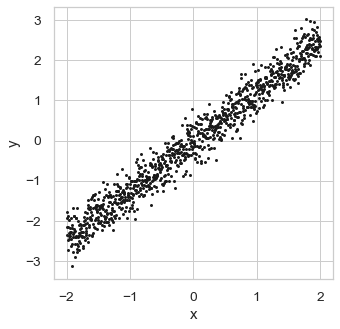

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
plt.plot(xtrain_N, ytrain_N, 'k.');
plt.xlabel('x');
plt.ylabel('y');

# Review: Gradient Descent for 1-dim. Linear Regression

## Define prediction model

Consider the *simplest* linear regression model. A single weight parameter $w \in \mathbb{R}$ representing the slope of the prediction line. No bias/intercept.

To make predictions, we just compute the weight multiplied by the input feature
$$
\hat{y}(x) = w \cdot x
$$

## Define loss function

We want to minimize the total *squared error* across all N observed data examples (input features $x_n$, output responses $y_n$)

Given a full dataset of $N$ examples, we can compute the loss as:

\begin{align}
    \min_{w \in \mathbb{R}} ~~ &\ell(w)
    \\
    \text{calc_loss}(w) = \ell(w) &= \frac{1}{N} \sum_{n=1}^N \frac{1}{2} (y_n - w x_n)^2
\end{align}

Given a random minibatch of $B$ examples, we can *estimate* the loss as:

\begin{align}
    \text{estimate_loss}(w) = &= \frac{1}{B} \sum_{n=1}^B \frac{1}{2} (y_n - w x_n)^2
\end{align}

### Exercise 1A: Complete the code below

You should make it match the math expression above. # CODE IS COMPLETED

In [7]:
def calc_loss(w, xbatch_B, ybatch_B):
    ''' Compute loss for slope-only least-squares linear regression
    
    Will compute the estimate of the loss given a minibatch of x,y values
    
    Args
    ----
    w : float
        Value of slope parameter

    Returns
    -------
    loss : float
        Mean of squared error loss at provided w value
    '''
    B = xbatch_B.shape[0]
    yhat_B = xbatch_B * w
    half_mean_squared_error = 0.5 * np.mean(np.square(ybatch_B - yhat_B))
    return half_mean_squared_error

### Define the gradient function

Given a full dataset of $N$ examples, we can compute the gradient as:

\begin{align}
\text{calc_grad}(w) = \ell'(w) &= \frac{1}{N} \frac{\partial}{\partial w} [ \sum_{n=1}^N \frac{1}{2} (y_n - w x_n)^2] 
\\
&= \frac{1}{N}  \sum_{n=1}^N (y_n - w x_n) (-x_n)
\\
&= \frac{1}{N} \sum_{n=1}^N (w x_n - y_n) (x_n)
\\
&= w \left( \frac{1}{N} \sum_{n=1}^N x_n^2 \right) - \frac{1}{N} \sum_{n=1}^N y_n x_n
\end{align}

Given a random minibatch of $B$ examples, we can *estimate* the gradient using:

\begin{align}
\text{estimate_grad}(w) &= \frac{1}{B} \frac{\partial}{\partial w} [ \sum_{n=1}^B \frac{1}{2} (y_n - w x_n)^2] 
\\
&= w \left( \frac{1}{B} \sum_{n=1}^B x_n^2 \right) - \frac{1}{B} \sum_{n=1}^B y_n x_n
\end{align}

Below, we've implemented the gradient calculation in code for you

In [8]:
def calc_grad(w, xbatch_B, ybatch_B):
    ''' Compute gradient for slope-only least-squares linear regression
    
    Will compute a deterministic estimate of the gradient given a minibatch of x,y values

    Args
    ----
    w : float
        Value of slope parameter

    Returns
    -------
    g : float
        Value of derivative of loss function at provided w value
    '''
    g = w * np.mean(np.square(xbatch_B)) - np.mean(xbatch_B * ybatch_B)
    return g

# Part 1: Stochastic estimates of the loss

### Plot whole-dataset loss evaluated at each w from -3 to 8

We should see a "bowl" shape with one *global* minima, because our optimization problem is "convex"

In [9]:
G = 101
w_grid = np.linspace(-3, 8, G) # create array of 300 values between -3 and 8
print(w_grid)

[-3.   -2.89 -2.78 -2.67 -2.56 -2.45 -2.34 -2.23 -2.12 -2.01 -1.9  -1.79
 -1.68 -1.57 -1.46 -1.35 -1.24 -1.13 -1.02 -0.91 -0.8  -0.69 -0.58 -0.47
 -0.36 -0.25 -0.14 -0.03  0.08  0.19  0.3   0.41  0.52  0.63  0.74  0.85
  0.96  1.07  1.18  1.29  1.4   1.51  1.62  1.73  1.84  1.95  2.06  2.17
  2.28  2.39  2.5   2.61  2.72  2.83  2.94  3.05  3.16  3.27  3.38  3.49
  3.6   3.71  3.82  3.93  4.04  4.15  4.26  4.37  4.48  4.59  4.7   4.81
  4.92  5.03  5.14  5.25  5.36  5.47  5.58  5.69  5.8   5.91  6.02  6.13
  6.24  6.35  6.46  6.57  6.68  6.79  6.9   7.01  7.12  7.23  7.34  7.45
  7.56  7.67  7.78  7.89  8.  ]


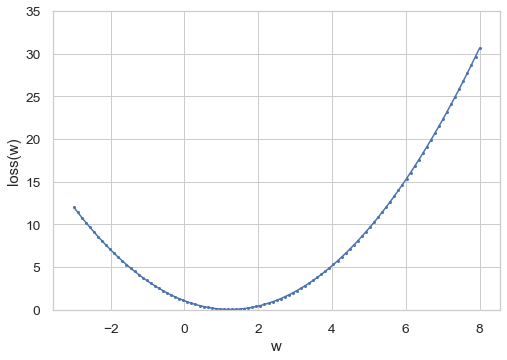

In [10]:
loss_grid = np.zeros(G)
for gg in range(G):
    loss_grid[gg] = calc_loss(w_grid[gg], xtrain_N, ytrain_N)

plt.plot(w_grid, loss_grid, 'b.-');
plt.xlabel('w');
plt.ylabel('loss(w)');
plt.ylim([0, 35]);

### Discussion 1a: Visually, at what value of $w$ does the loss function have a minima? Is it near where you would expect (hint: look above for the "true" slope value used to generate the data)

In [11]:
print("At", w_grid[np.argmin(loss_grid)])

# It is close enough to the true value of w, which is 1.234.

At 1.1799999999999997


### Sampling a minibatch of size B

We have provided some starter code that samples a minibatch of B examples from a training set of N examples

Uses a provided `random_state` pseudo-random number generator, which defaults to numpy's if not specified.

In [12]:
def draw_minibatch(xtrain_N, ytrain_N, batch_size=100, random_state=np.random):
    ''' Sample a minibatch of desired size from provided training set
    
    Returns
    -------
    xbatch_B : 1D array, size (B,)
        x values of minibatch
    ybatch_B : 1D array, size (B,)
        y values of minibatch
    '''
    N = ytrain_N.size
    selected_row_ids = random_state.choice(np.arange(N), size=batch_size, replace=False)
    xbatch_B = xtrain_N[selected_row_ids].copy()
    ybatch_B = ytrain_N[selected_row_ids].copy()
    return xbatch_B, ybatch_B

### Show several minibatches of size 1

In [13]:
draw_minibatch(xtrain_N, ytrain_N, 1)

(array([-0.8028028]), array([-0.87964189]))

In [14]:
draw_minibatch(xtrain_N, ytrain_N, 1)

(array([1.21521522]), array([1.38221046]))

In [15]:
draw_minibatch(xtrain_N, ytrain_N, 1)

(array([-0.86286286]), array([-0.97886967]))

### Show example minibatch of size 500


In [16]:
xbatch_B, ybatch_B = draw_minibatch(xtrain_N, ytrain_N, 500)

print("Showing first 5 entries of x array of shape %s" % str(xbatch_B.shape))
print(xbatch_B[:5])
print("Showing first 5 entries of y array of shape %s" % str(ybatch_B.shape))
print(ybatch_B[:5])

Showing first 5 entries of x array of shape (500,)
[ 0.46646647  1.0950951   0.89089089 -0.07807808 -0.24224224]
Showing first 5 entries of y array of shape (500,)
[ 0.64277269  1.4091735   1.15453701  0.13507344 -0.27544887]


### Exercise 1b: Would you expect the loss on the minibatch to be better at $w=1.0$ or at $w = -1.0$?

TODO write answer here to guess, then use code below to figure it out.

My guess is that it would be better at w=1.0 since that is the true value of w, and so that's we want to optimize on.

Show the loss at this random minibatch when $w = 1.0$

In [17]:
calc_loss(1.0, xbatch_B, ybatch_B)

0.080839159718721

Show the loss at this random minibatch when w = -1.0

In [18]:
calc_loss(-1.0, xbatch_B, ybatch_B)

3.29508054716685

### Exercise 1c: Can you draw a random minibatch of size 25 and display *all* of it?

In [20]:
xbatch_25, ybatch_25 = draw_minibatch(xtrain_N, ytrain_N, 25) # TODO use draw_minibatch

print("Showing x array")
print(xbatch_25)
print("Showing y array")
print(ybatch_25)


Showing x array
[ 1.50750751  0.9029029  -1.4034034   1.67967968 -0.67467467 -1.49149149
  0.81081081 -1.46346346  0.56256256 -0.89089089  1.01501502 -1.56756757
 -0.78278278  1.68768769  1.29129129  0.34234234 -1.35135135 -0.40640641
  0.26226226  0.71071071 -1.33133133  1.43943944 -0.37037037  0.68668669
  0.09409409]
Showing y array
[ 1.79352116  0.8480279  -1.87027518  2.0268924  -1.18923204 -1.28572138
  0.76393976 -1.99666774  0.6670876  -1.13419054  1.761383   -1.35749577
 -0.76603903  2.46542921  1.34215004  0.28125915 -1.38274133 -0.06153189
  0.38259885  1.18212331 -2.10629419  1.78388983 -0.43935936  0.28199562
 -0.1505793 ]


### Exercise 1d: What is the loss at your minibatch at $w=1.0$ and $w = 1.5$?

In [21]:
# TODO your code here, call calc_loss
calc_loss(1.0, xbatch_25, ybatch_25)

0.0720799651915777

In [22]:
calc_loss(1.5, xbatch_25, ybatch_25)

0.10378612994898723

## Plot: Compute the *stochastic estimate* of loss as a function of $w$, using batch size 50

We'll make 3 lines, for 3 separate *trials* of this procedure, so we can see how much each trial's curve might vary

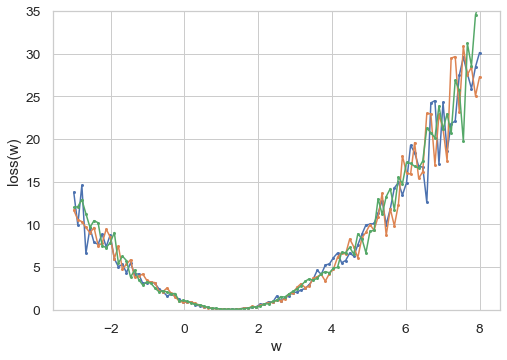

In [23]:
for trial in range(3):
    random_state = np.random.RandomState(trial) # set seed based on the trial id

    stoch_loss_grid = np.zeros(G)
    for gg in range(G):
        xbatch_B, ybatch_B = draw_minibatch(xtrain_N, ytrain_N, batch_size=50, random_state=random_state)
        stoch_loss_grid[gg] = calc_loss(w_grid[gg], xbatch_B, ybatch_B)

    plt.plot(w_grid, stoch_loss_grid, '.-', label='Trial %d' % trial);
plt.xlabel('w');
plt.ylabel('loss(w)');
plt.ylim([0, 35]);

## Exercise 1e: Compute stochastic estimate of loss as function of w, for batch_size = 5

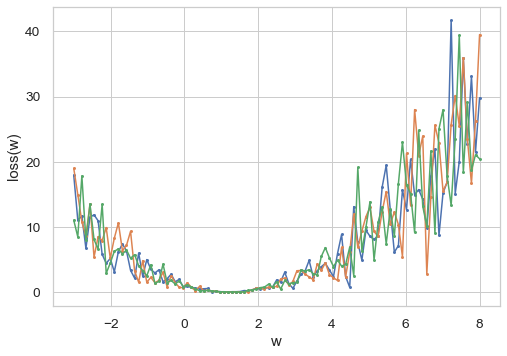

In [24]:
for trial in range(3):
    random_state = np.random.RandomState(trial) # set seed based on the trial id

    stoch_loss_grid = np.zeros(G)
    for gg in range(G):
        xbatch_B, ybatch_B = draw_minibatch(xtrain_N, ytrain_N, 5) # TODO use draw_minibatch
        stoch_loss_grid[gg] = calc_loss(w_grid[gg], xbatch_B, ybatch_B)   # TODO use calc_loss at the current batch

    plt.plot(w_grid, stoch_loss_grid, '.-', label='Trial %d' % trial);
    
    
plt.xlabel('w');
plt.ylabel('loss(w)');

## Exercise 1f: Compute stochastic estimate of loss as function of w, for batch_size = 1

Repeat the above for batch_size = 1

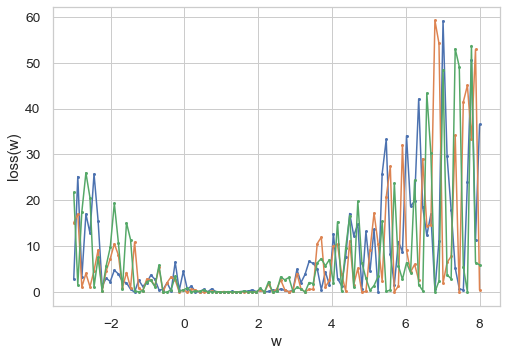

In [25]:
for trial in range(3):
    random_state = np.random.RandomState(trial) # set seed based on the trial id

    stoch_loss_grid = np.zeros(G)
    for gg in range(G):
        xbatch_B, ybatch_B = draw_minibatch(xtrain_N, ytrain_N, 1) # TODO use draw_minibatch
        stoch_loss_grid[gg] = calc_loss(w_grid[gg], xbatch_B, ybatch_B)   # TODO use calc_loss at the current batch

    plt.plot(w_grid, stoch_loss_grid, '.-', label='Trial %d' % trial);
    
    
plt.xlabel('w');
plt.ylabel('loss(w)');

## Discussion 1f: What can you say about the *variance* of the stochastic estimates

How does variance change as a function of batch size ?

## Part 2: Stochastic estimates of the gradient

## Sanity check: plot whole dataset gradient evaluated at each w from -3 to 8

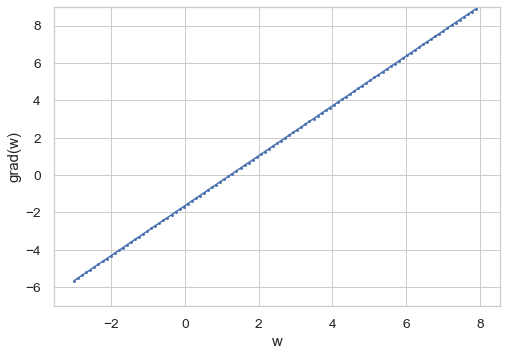

In [26]:
grad_grid = np.zeros(G)
for gg in range(G):
    grad_grid[gg] = calc_grad(w_grid[gg], xtrain_N, ytrain_N)

plt.plot(w_grid, grad_grid, 'b.-');
plt.xlabel('w');
plt.ylabel('grad(w)');
plt.ylim([-7, 9]);

## Plot: Compute the *stochastic estimate* of grad as a function of $w$, using batch size 50

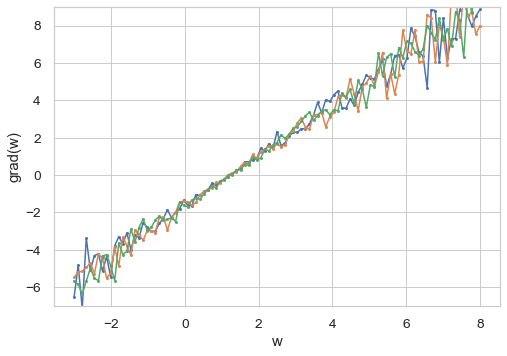

In [27]:
for trial in range(3):
    random_state = np.random.RandomState(trial) # set seed based on the trial id

    stoch_grad_grid = np.zeros(G)
    for gg in range(G):
        xbatch_B, ybatch_B = draw_minibatch(xtrain_N, ytrain_N, batch_size=50, random_state=random_state)
        stoch_grad_grid[gg] = calc_grad(w_grid[gg], xbatch_B, ybatch_B)
        
    plt.plot(w_grid, stoch_grad_grid, '.-', label='Trial %d' % trial);
    

plt.xlabel('w');
plt.ylabel('grad(w)');
plt.ylim([-7, 9]);

## Exercise 2a: Repeat the above plot at batch_size = 5


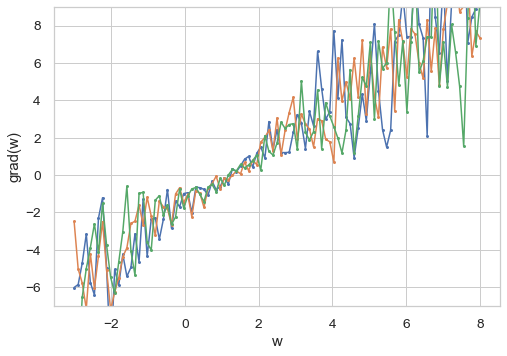

In [30]:
for trial in range(3):
    random_state = np.random.RandomState(trial) # set seed based on the trial id

    stoch_grad_grid = np.zeros(G)
    for gg in range(G):
        xbatch_B, ybatch_B = draw_minibatch(xtrain_N, ytrain_N, batch_size=5, random_state=random_state) # TODO use draw_minibatch
        stoch_grad_grid[gg] = calc_grad(w_grid[gg], xbatch_B, ybatch_B) # TODO use calc_grad
        
    plt.plot(w_grid, stoch_grad_grid, '.-', label='Trial %d' % trial);
    

plt.xlabel('w');
plt.ylabel('grad(w)');
plt.ylim([-7, 9]);

## Exercise 2c: Repeat the above plot at batch_size = 1


TODO copy code from above.

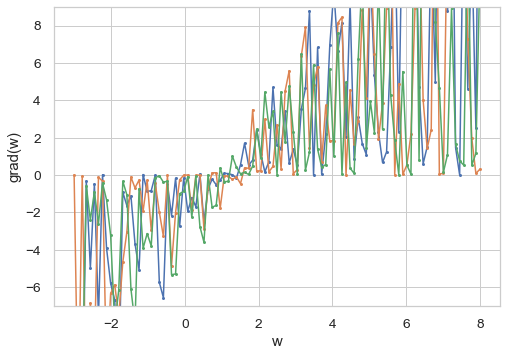

In [31]:
# TODO

for trial in range(3):
    random_state = np.random.RandomState(trial) # set seed based on the trial id

    stoch_grad_grid = np.zeros(G)
    for gg in range(G):
        xbatch_B, ybatch_B = draw_minibatch(xtrain_N, ytrain_N, batch_size=1, random_state=random_state) # TODO use draw_minibatch
        stoch_grad_grid[gg] = calc_grad(w_grid[gg], xbatch_B, ybatch_B) # TODO use calc_grad
        
    plt.plot(w_grid, stoch_grad_grid, '.-', label='Trial %d' % trial);
    

plt.xlabel('w');
plt.ylabel('grad(w)');
plt.ylim([-7, 9]);

## Discussion 2d: What happens to the variance of the grad estimate as batch_size increases?
the variance decreases

## Discussion 2d: What happens to the cost of computing the estimate as batch_size increases?

It increases, since there are more points to compute the loss/gradient.


## Part 3: Stochastic Gradient Descent (GD) as an algorithm in Python

### Define minimize_via_sgd algorithm

Can you understand what each step of this algorithm does?

In [32]:
def minimize_via_sgd(xtrain_N, ytrain_N, init_w=0.0, batch_size=10, step_size=0.001, max_iters=100, random_state=0):
    ''' Perform minimization of provided loss function via gradient descent
    
    Each "iteration" performs one or more gradient updates, until total training set has been "seen"
    
    Args
    ----
    xtrain_N : numpy array, shape (N,)
    ytrain_N : numpy array, shape (N,)
    init_w : float
    batch_size : int
    step_size : float
    max_iters : positive int
    
    Return
    ----
    wopt: float
        array of optimized weights that approximately gives the least error
    info_dict : dict
        Contains information about the optimization procedure useful for debugging
        Entries include:
        * trace_loss_list : list of loss values
        * trace_grad_list : list of gradient values
    '''
    N = int(ytrain_N.size)
    B = int(batch_size)
    
    if isinstance(random_state, int):
        random_state = np.random.RandomState(random_state)

    w = 1.0 * init_w 
    
    # Create some lists to track progress over time (for debugging)
    trace_loss_list = []
    trace_w_list = []
    trace_grad_list = []

    step_id = 0
    for iter_id in range(max_iters):
        
        n_examples_seen_this_iter = 0
        while n_examples_seen_this_iter < N:
            xbatch_B, ybatch_B = draw_minibatch(xtrain_N, ytrain_N, batch_size, random_state=random_state)
            n_examples_seen_this_iter += batch_size
            
            loss = calc_loss(w, xbatch_B, ybatch_B)    
            grad = calc_grad(w, xbatch_B, ybatch_B)    
            w = w - step_size * grad
            step_id += 1

        print("  iter %5d/%d done | step %5d | w  % 13.5f | loss % 13.4f | grad % 13.4f" % (
            iter_id, max_iters, step_id, w, loss, grad))
    
        trace_loss_list.append(loss)
        trace_w_list.append(w)
        trace_grad_list.append(grad)
    
    wopt = w
    info_dict = dict(
        trace_loss_list=trace_loss_list,
        trace_w_list=trace_w_list, 
        trace_grad_list=trace_grad_list)
    
    return wopt, info_dict

### Discussion 2a: Which line of the above function does the *parameter update* happen?

Remember, in math, the parameter update of gradient descent is this:
$$
w \gets w - \alpha \nabla_w \ell(w)
$$

where $\alpha > 0$ is the step size.

In words, this math says *move* the parameter $w$ from its current value a *small step* in the "downhill" direction (indicated by gradient).

TODO write down here which line above *you* think it is, then discuss with your group

In [33]:
# line 48: w = w - step_size * grad

### Try it! Run SGD with step_size = 0.01 and batch_size = 200

Running the cell below will have the following effects:

1) one line will be printed for every iteration, indicating the current w value and its associated loss

2) the "optimal" value of w will be stored in the variable named `wopt` returned by this function

3) a dictionary of information useful for debugging will be stored in the `info_dict` returned by this function

In [34]:
wopt, info_dict = minimize_via_sgd(xtrain_N, ytrain_N, step_size=0.01, batch_size=200);

  iter     0/100 done | step     5 | w        0.08015 | loss        1.0488 | grad       -1.7202
  iter     1/100 done | step    10 | w        0.15328 | loss        0.8576 | grad       -1.4773
  iter     2/100 done | step    15 | w        0.22259 | loss        0.7444 | grad       -1.3535
  iter     3/100 done | step    20 | w        0.28735 | loss        0.6190 | grad       -1.2232
  iter     4/100 done | step    25 | w        0.35058 | loss        0.5804 | grad       -1.2300
  iter     5/100 done | step    30 | w        0.40936 | loss        0.5670 | grad       -1.2455
  iter     6/100 done | step    35 | w        0.46134 | loss        0.4426 | grad       -1.0366
  iter     7/100 done | step    40 | w        0.51053 | loss        0.3971 | grad       -0.9791
  iter     8/100 done | step    45 | w        0.55889 | loss        0.3367 | grad       -0.8819
  iter     9/100 done | step    50 | w        0.60231 | loss        0.3295 | grad       -0.8519
  iter    10/100 done | step    55 | w  

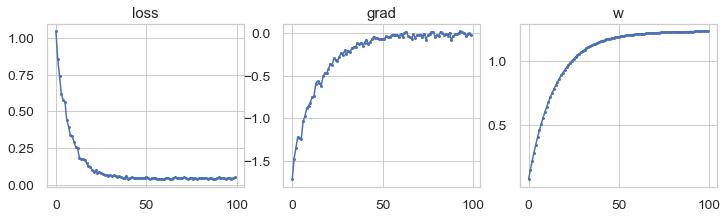

In [35]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=False, figsize=(12,3))

axes[0].plot(info_dict['trace_loss_list'], '.-');
axes[0].set_title('loss');
axes[1].plot(info_dict['trace_grad_list'], '.-');
axes[1].set_title('grad');
axes[2].plot(info_dict['trace_w_list'], '.-');
axes[2].set_title('w');

### Discussion 2b: Does it appear from the *parameter* values in trace above that the SGD procedure converged?

yes, because w is stable

### Discussion 2c: Does it appear from the *loss* values in trace above that the SGD procedure converged?
yes, in the plot, the loss converges to 0

### Discussion 2d: Does it appear from the *grad* values in trace above that the SGD procedure converged?
yes, in the plot, the grad converges to 0 as well
.

## Try with smaller batch_size = 10

In [36]:
wopt, info_dict = minimize_via_sgd(xtrain_N, ytrain_N, step_size=0.01, batch_size=10);

  iter     0/100 done | step   100 | w        0.91625 | loss        0.1191 | grad       -0.3511
  iter     1/100 done | step   200 | w        1.14951 | loss        0.0377 | grad        0.0505
  iter     2/100 done | step   300 | w        1.20424 | loss        0.0991 | grad        0.1091
  iter     3/100 done | step   400 | w        1.23031 | loss        0.0381 | grad        0.0042
  iter     4/100 done | step   500 | w        1.23886 | loss        0.0511 | grad       -0.2389
  iter     5/100 done | step   600 | w        1.24595 | loss        0.0859 | grad       -0.1187
  iter     6/100 done | step   700 | w        1.25205 | loss        0.0334 | grad        0.1019
  iter     7/100 done | step   800 | w        1.23007 | loss        0.0334 | grad       -0.0147
  iter     8/100 done | step   900 | w        1.22628 | loss        0.0573 | grad        0.0265
  iter     9/100 done | step  1000 | w        1.23810 | loss        0.0412 | grad        0.0452
  iter    10/100 done | step  1100 | w  

  iter    95/100 done | step  9600 | w        1.24039 | loss        0.0208 | grad       -0.0708
  iter    96/100 done | step  9700 | w        1.23499 | loss        0.0839 | grad        0.0251
  iter    97/100 done | step  9800 | w        1.23123 | loss        0.0467 | grad        0.0922
  iter    98/100 done | step  9900 | w        1.23677 | loss        0.0182 | grad        0.0165
  iter    99/100 done | step 10000 | w        1.22925 | loss        0.0492 | grad        0.0620


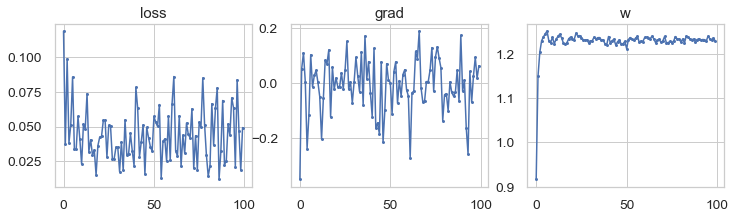

In [37]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=False, figsize=(12,3))

axes[0].plot(info_dict['trace_loss_list'], '.-');
axes[0].set_title('loss');
axes[1].plot(info_dict['trace_grad_list'], '.-');
axes[1].set_title('grad');
axes[2].plot(info_dict['trace_w_list'], '.-');
axes[2].set_title('w');

### Try with even smaller batch_size of 1

In [42]:
# TODO write code here

wopt, info_dict = minimize_via_sgd(xtrain_N, ytrain_N, step_size=0.01, batch_size=1);

  iter     0/100 done | step  1000 | w        1.23833 | loss        0.0090 | grad        0.2675
  iter     1/100 done | step  2000 | w        1.24311 | loss        0.0342 | grad        0.1084
  iter     2/100 done | step  3000 | w        1.22439 | loss        0.0282 | grad       -0.2963
  iter     3/100 done | step  4000 | w        1.18008 | loss        0.0543 | grad       -0.0033
  iter     4/100 done | step  5000 | w        1.20593 | loss        0.0096 | grad        0.1081
  iter     5/100 done | step  6000 | w        1.19016 | loss        0.0238 | grad        0.0520
  iter     6/100 done | step  7000 | w        1.23273 | loss        0.0355 | grad        0.0251
  iter     7/100 done | step  8000 | w        1.24029 | loss        0.0135 | grad        0.1538
  iter     8/100 done | step  9000 | w        1.22694 | loss        0.0393 | grad        0.3789
  iter     9/100 done | step 10000 | w        1.21816 | loss        0.1192 | grad        0.2180
  iter    10/100 done | step 11000 | w  

  iter    88/100 done | step 89000 | w        1.23818 | loss        0.0095 | grad        0.0908
  iter    89/100 done | step 90000 | w        1.19183 | loss        0.0468 | grad        0.5004
  iter    90/100 done | step 91000 | w        1.21812 | loss        0.1590 | grad       -0.3240
  iter    91/100 done | step 92000 | w        1.24120 | loss        0.0068 | grad        0.0208
  iter    92/100 done | step 93000 | w        1.23439 | loss        0.0017 | grad        0.0132
  iter    93/100 done | step 94000 | w        1.22095 | loss        0.0607 | grad        0.6454
  iter    94/100 done | step 95000 | w        1.21147 | loss        0.0890 | grad       -0.2356
  iter    95/100 done | step 96000 | w        1.22286 | loss        0.0521 | grad        0.3430
  iter    96/100 done | step 97000 | w        1.21069 | loss        0.0009 | grad        0.0692
  iter    97/100 done | step 98000 | w        1.24845 | loss        0.0021 | grad       -0.0226
  iter    98/100 done | step 99000 | w  

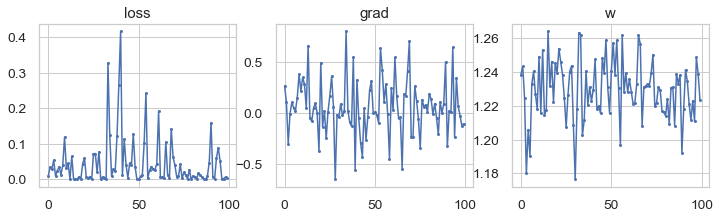

In [44]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=False, figsize=(12,3))

axes[0].plot(info_dict['trace_loss_list'], '.-');
axes[0].set_title('loss');
axes[1].plot(info_dict['trace_grad_list'], '.-');
axes[1].set_title('grad');
axes[2].plot(info_dict['trace_w_list'], '.-');
axes[2].set_title('w');

### Discussion 3b: What happens here with this smaller batch size? Is it converging?

no

# Part 5: SGD for MLPClassifier



Let's revisit the XOR dataset from our previous lab, and try SGD for it.

In [45]:
def make_xor_dataset(n_per_blob=50, stddev=0.4, random_state=0):
    random_state = np.random.RandomState(random_state)
    cov_22 = np.square(stddev) * np.eye(2)
    x_00 = random_state.multivariate_normal([-1, -1], cov_22, size=n_per_blob)
    x_01 = random_state.multivariate_normal([-1, +1], cov_22, size=n_per_blob)
    x_10 = random_state.multivariate_normal([+1, -1], cov_22, size=n_per_blob)
    x_11 = random_state.multivariate_normal([+1, +1], cov_22, size=n_per_blob)

    N = n_per_blob * 4
    x_N2 = np.vstack([x_00, x_11, x_01, x_10])
    assert x_N2.shape == (N, 2)

    y_N = np.hstack([np.ones(N//2), np.zeros(N//2)]).astype(np.int32)
    assert y_N.shape == (N,)

    # Shuffle the order
    perm_ids = random_state.permutation(N)
    x_N2 = x_N2[perm_ids].copy()
    y_N = y_N[perm_ids].copy()

    return x_N2, y_N

In [46]:
x_tr_N2, y_tr_N = make_xor_dataset(n_per_blob=50)

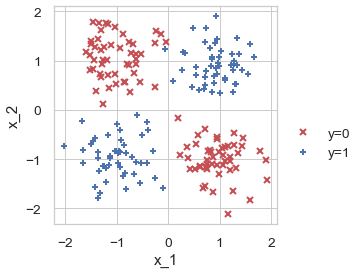

In [47]:
plt.figure(figsize=(4,4))
plt.plot(x_tr_N2[y_tr_N==0,0], x_tr_N2[y_tr_N==0,1], 'rx', label='y=0', mew=2);
plt.plot(x_tr_N2[y_tr_N==1,0], x_tr_N2[y_tr_N==1,1], 'b+', label='y=1', mew=2);

plt.xlabel('x_1');
plt.ylabel('x_2');
plt.legend(bbox_to_anchor=(1.0, 0.5));

# Setup: Create Utility function for visualizing classifier predictions

You do NOT need to understand the details of this function. We'll just use it as is.

In [48]:
def plot_pretty_probabilities_for_clf(
        clf,
        ax=None,
        x1_grid=(-2.1, 2.1, 50), x2_grid=(-2.1, 2.1, 50),
        x1_ticks=[-1, 0, 1], x2_ticks=[-1, 0, 1],
        do_show_colorbar=False,
        c_ticks=np.asarray([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]),
        c_num_levels=100,
        ):
    ''' Display predicted probabilities from classifier as color contour plot

    Args
    ----
    clf : sklearn object that implements classifier API
    ax : matplotlib axis handle, or None
        If provided, will use axis handle as primary axis to plot on.
        If None, will use the current handle, or make new one as necessary.
    x1_grid : tuple-like or array-like
        If tuple of length 3, interpreted as args to np.linspace
        Otherwise, cast to array and assumed to be a 1d grid of x1 values
    x2_grid : tuple-like or array-like
        If tuple of length 3, interpreted as args to np.linspace
        Otherwise, cast to array and assumed to be a 1d grid of x2 values

    '''
    # Activate the current axis, if necessary
    if ax is None:
        cur_ax = plt.gca()
    else:
        cur_ax = ax
        plt.sca(cur_ax)

    # Create dense grid of x1 and x2 values
    # useful for visualizing probabilities
    if isinstance(x1_grid, tuple) and len(x1_grid) == 3:
        x1_grid = np.linspace(x1_grid[0], x1_grid[1], x1_grid[2])
    if isinstance(x2_grid, tuple) and len(x2_grid) == 3:
        x2_grid = np.linspace(x2_grid[0], x2_grid[1], x2_grid[2])
    x1_grid = np.asarray(x1_grid).flatten()
    x2_grid = np.asarray(x2_grid).flatten()

    c_levels = np.linspace(0.0, 1.0, c_num_levels)

    # Get regular grid of G x H points, where each point is an (x1, x2) location
    G = x1_grid.size
    H = x2_grid.size    
    x1_GH, x2_GH = np.meshgrid(x1_grid, x2_grid)
    
    # Combine the x1 and x2 values into one array
    # Flattened into M = G x H rows
    # Each row of x_M2 is a 2D vector [x_m1, x_m2]
    x_M2 = np.hstack([x1_GH.flatten()[:,np.newaxis], x2_GH.flatten()[:,np.newaxis]])
    
    # Predict proba for each point in the flattened grid
    yproba1_M = clf.predict_proba(x_M2)[:,1]
    # Reshape the M probas into the GxH 2D field
    yproba1_GH = np.reshape(yproba1_M, x1_GH.shape)
    # Contour plot
    cmap = plt.cm.RdYlBu
    my_contourf_h = plt.contourf(
            x1_GH, x2_GH, yproba1_GH,
            levels=c_levels, vmin=0, vmax=1.0,
            cmap=cmap, alpha=0.5)

    # Edit the ticks observed
    if x1_ticks is not None:
        plt.xticks(x1_ticks, x1_ticks);
    if x2_ticks is not None:
        plt.yticks(x2_ticks, x2_ticks);
    if do_show_colorbar:
        left, bottom, width, height = plt.gca().get_position().bounds
        cax = plt.gcf().add_axes([left + 1.1*width, bottom, 0.03, height])
        plt.colorbar(my_contourf_h, orientation='vertical', cax=cax, ticks=c_ticks);
        plt.sca(cur_ax);

## Try an MLP with 2 hidden units, batch size of 25

This time, we'll use SGD as built in solver

In [49]:
mlp_2hidden_run5 = sklearn.neural_network.MLPClassifier(
    hidden_layer_sizes=[2],
    activation='relu',
    solver='sgd',
    learning_rate_init=0.1,
    random_state=5,
    batch_size=25,
    )

In [50]:
# Fit the model to training data

mlp_2hidden_run5.fit(x_tr_N2, y_tr_N)

MLPClassifier(batch_size=25, hidden_layer_sizes=[2], learning_rate_init=0.1,
              random_state=5, solver='sgd')

### Visualize the results using our utility function


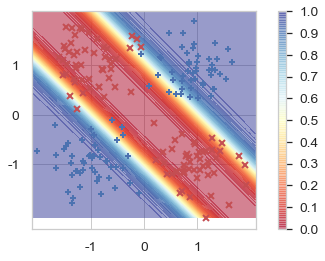

In [51]:
plt.figure(figsize=(4,4))
plot_pretty_probabilities_for_clf(mlp_2hidden_run5, do_show_colorbar=True, ax=plt.gca());

plt.plot(x_tr_N2[y_tr_N==0,0], x_tr_N2[y_tr_N==0,1], 'rx', label='y=0', mew=2);
plt.plot(x_tr_N2[y_tr_N==1,0], x_tr_N2[y_tr_N==1,1], 'b+', label='y=1', mew=2);

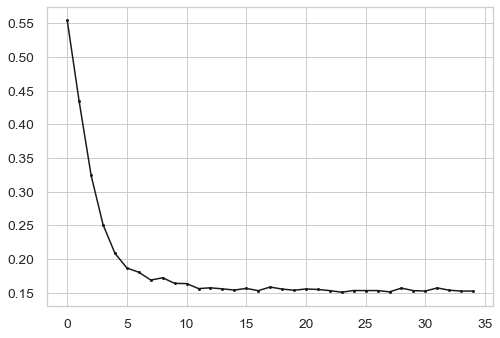

In [52]:
### Visualize the trace of the loss

plt.plot(mlp_2hidden_run5.loss_curve_, 'k.-')

# Try several trials with batch_size of 25

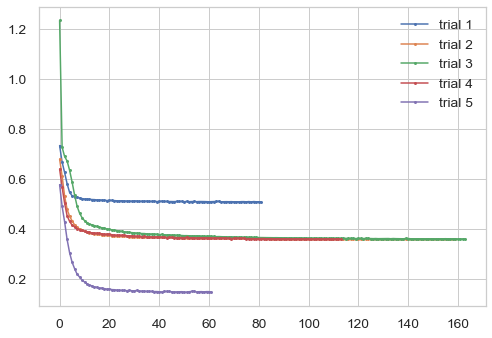

In [54]:
for trial in [1, 2, 3, 4, 5]:
    mlp_2hidden_batchsize25 = sklearn.neural_network.MLPClassifier(
        hidden_layer_sizes=[2],
        activation='relu',
        solver='sgd',
        learning_rate_init=0.05,
        random_state=trial,
        batch_size=25,
        )
    
    # Fit the model to training data
    mlp_2hidden_batchsize25.fit(x_tr_N2, y_tr_N)
    
    # Visualize the trace of the loss
    plt.plot(mlp_2hidden_batchsize25.loss_curve_, '.-', label='trial %d' % trial)
    
plt.legend();

### Now try several trials with a batch_size of 1

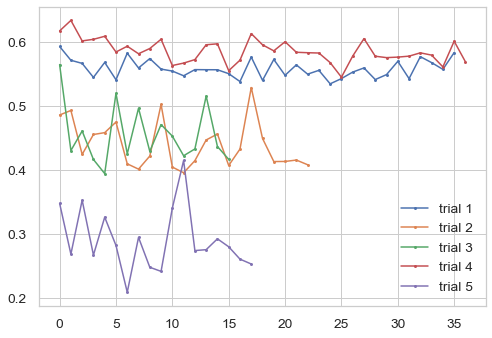

In [56]:
for trial in [1, 2, 3, 4, 5]:
    mlp_2hidden_batchsize1 = sklearn.neural_network.MLPClassifier(
        hidden_layer_sizes=[2],
        activation='relu',
        solver='sgd',
        learning_rate_init=0.05,
        random_state=trial,
        batch_size=1,
        )
    
    # Fit the model to training data
    mlp_2hidden_batchsize1.fit(x_tr_N2, y_tr_N)
    
    # Visualize the trace of the loss
    plt.plot(mlp_2hidden_batchsize1.loss_curve_, '.-', label='trial %d' % trial)
    
plt.legend();

### Discussion 4a: What is happening here?

In [ ]:
# the loss does not converge when using batch of size 1
